# Velocity gradients and divergence in HC3N structure

We calculate the velocity gradients $\nabla$v of the velocity field of each molecule. This will tell us about local motions within the fibers and possibly ordered infall toward the fiber spines. 

We also compare the velocity gradients with the polarization vectors to see if the kinematics are influenced by magnetic fields.

For this, first we need the velocity gradient of HC3N and N2Hp$\nabla$v. We calculated the HC3N and N2Hp gradients in their native resolution for each cluster. We are missing to do this in the same resolution. From 'clustering/comparison_velocities_N2Hp_HC3N.ipynb' we have the clusters velocities in the same pixel grid.

(this was a failed experiment, the divergence did not tell us anything useful)
We analyse if the divergence of the velocity gradients $\nabla \cdot \nabla$v can give us a clue if infall is hiding within all the outflow activity in HC3N. The velocity gradients will tell us how the mass accelerates, the divergence will indicate any changes in this behavior.





In [1]:
import numpy as np
import os
import scipy.linalg # for initial guesses
from scipy.optimize import curve_fit # to obtain the fit with errors
from astropy.io import fits, ascii
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from matplotlib import cm
from astropy.coordinates import SkyCoord
import pandas as pd
%matplotlib widget

In [2]:
# HC3N1gfile = '../bayes_frame/nested-sampling/HC3N/NGC1333-SE-mle-x1_filtered_QA.fits'
# HC3N1gfile = '../clustering/cluster1_HC3N_w0.5_r2.fits' # this is all the 1 gaussian component fit plus the closest 2 and 3 gaussians to fill the gaps
HC3N1gfile = '../clustering/clusters_red_HC3N_reproject.fits'
molecule = 'HC3N' # we modify to use several molecules
clump = 'red_reproject'

# to save

savefolder = 'gradients/'
velgradbasefile = savefolder + 'vel_grad_{0}_{1}_{2}.fits'
# velgradxfile = velgradbasefile.format('x', molecule, clump)
# e_velgradxfile = velgradbasefile.format('x_unc', molecule, clump)
# velgradyfile = velgradbasefile.format('y', molecule, clump)
# e_velgradyfile = velgradbasefile.format('y_unc', molecule, clump)
velgradamplfile = velgradbasefile.format('magnitude', molecule, clump)
# e_velgradamplfile = velgradbasefile.format('magnitude_unc', molecule, clump)
# velgradvclfile = velgradbasefile.format('vc', molecule, clump)
# e_velgradvclfile = velgradbasefile.format('vc_unc', molecule, clump)

velgradpropertiesfile = savefolder + 'vel_grad_properties_{0}_{1}.fits'.format(molecule, clump)

overwrite = True

## Calculating velocity gradients


In principle, we need to sample at least 2 beams, so that the values are uncorrelated


In [3]:
# load the velocity and its associated uncertainty
params, parheader = fits.getdata(HC3N1gfile, header=True)
velfield = params[1] # km/s
velerror = params[4]
# load the sky WCS
wcssky = WCS(parheader).celestial
# load the beam size
beammaj, beammin, bpa = (parheader['BMAJ'], parheader['BMIN'], parheader['BPA']) * u.deg
pixsize = np.abs(parheader['CDELT2']) * u.deg
nbeams = 2
equivradius = np.sqrt(beammaj * beammin / (4 * np.log(2)))  #equivalence with solid angle of beam in radius form
equivradiuspix = (equivradius / pixsize).value # radius in pixels
sampleradiuspix = int(np.round(nbeams* equivradiuspix, 0))
minarea_calc = (np.pi * sampleradiuspix ** 2) / 3 #at least a third of pixels in the area must be available
print("Running program for a gradient with a width of {} beams".format(nbeams))
pixsize_pc = (((pixsize.to(u.arcsec) * 298).value) * u.au).to(u.pc).value # parsec per pixel
pixsize_au = (((pixsize.to(u.arcsec) * 298).value) * u.au).value # au per pixel
print("Beam size: {0} x {1}".format(np.round(beammaj.to(u.arcsec), 1), np.round(beammin.to(u.arcsec), 1)))
print("The equivalent radius is {0} pixels, the sample radius is {1}, needs a minimum of {2} pixels".format(np.round(equivradiuspix, 1), np.round(sampleradiuspix, 1), np.round(minarea_calc, 1)))

# tolerance parameter for the linear algebra
epsilon = 1e-3

Running program for a gradient with a width of 2 beams
Beam size: 4.9 arcsec x 4.7 arcsec
The equivalent radius is 3.2 pixels, the sample radius is 6, needs a minimum of 37.7 pixels


In [4]:
def plane(X, A, B, vc):
    xpos, ypos = X
    return A*xpos + B*ypos + vc

def gradient(scalarfield, e_scalarfield, radius, minarea, pixunit, eps=1e-3):
    filled_indices = np.where(~np.isnan(scalarfield))
    gx = np.zeros(np.shape(scalarfield)) * np.nan
    e_gx = np.zeros(np.shape(scalarfield)) * np.nan
    gy = np.zeros(np.shape(scalarfield)) * np.nan
    e_gy = np.zeros(np.shape(scalarfield)) * np.nan
    constant = np.zeros(np.shape(scalarfield)) * np.nan
    e_constant = np.zeros(np.shape(scalarfield)) * np.nan
    magnitude = np.zeros(np.shape(scalarfield)) * np.nan
    e_magnitude = np.zeros(np.shape(scalarfield)) * np.nan
    jumped = 0
    for y, x in zip(filled_indices[0], filled_indices[1]):
        sampleregion = scalarfield[y-radius:y+radius+1, x-radius:x+radius+1]
        sampleerror = e_scalarfield[y-radius:y+radius+1, x-radius:x+radius+1]
        X,Y = np.meshgrid(np.arange(-radius, radius+1, 1), np.arange(-radius, radius+1, 1))
        if (np.shape(sampleregion)[0] != np.shape(sampleregion)[1]): continue
        index_sampleregion_filter = np.where(~np.isnan(sampleregion))
        if len(index_sampleregion_filter[0]) < minarea:
            jumped+=1
            # print('jumped {} {}'.format(x, y), index_sampleregion_filter[0])
            continue
        else:
            # we define the X and Y positions
            # we need to get the gradient in km/s/pc
            X_pc = X[index_sampleregion_filter] * pixunit
            Y_pc = Y[index_sampleregion_filter] * pixunit
            sampleregion_filtered = sampleregion[index_sampleregion_filter]
            sampleerror_filtered = sampleerror[index_sampleregion_filter]
            data_sample = np.transpose([X_pc, Y_pc, sampleregion_filtered])

            # we obtain the initial guesses
            A = np.c_[data_sample[:,0],data_sample[:,1], np.ones(data_sample.shape[0])] # design matrix X, Y, constants
            C,_,_,_ = scipy.linalg.lstsq(A, data_sample[:,2])
            if np.abs(C[0])< eps or np.abs(C[1])< eps: continue
            A0 = C[0]
            B0 = C[1]
            vc0 = C[2]
            # now we fit with the error map as well
            popt, pcov = curve_fit(plane, (X_pc, Y_pc), sampleregion_filtered, p0=[A0, B0, vc0], sigma=sampleerror_filtered, absolute_sigma=True) 
            #values
            gx[y, x] = popt[0]
            gy[y, x] = popt[1]
            constant[y, x] = popt[2]
            magnitude[y, x] = np.sqrt(popt[1]**2 + popt[0]**2)
            #uncertainties
            perr = np.sqrt(np.diag(pcov))
            e_gx[y, x] = perr[0]
            e_gy[y, x] = perr[1]
            e_constant[y, x] = perr[2]
            e_magnitude[y, x] = np.sqrt(perr[0]**2 + perr[1]**2)
            
    values = [gx, gy, constant, magnitude]
    errors = [e_gx, e_gy, e_constant, e_magnitude]
    return values, errors, jumped

In [5]:

if not os.path.exists(velgradpropertiesfile) or overwrite:
# if not os.path.exists(velgradxfile) or not os.path.exists(velgradxfile) or overwrite:
    values_grad, errors_grad, jumped_grad = gradient(velfield, velerror, sampleradiuspix, minarea_calc, pixsize_pc, eps=1e-3)
    # gradheader = wcssky.to_header()
    gradheader = parheader.copy()
    gradheader['BUNIT'] = 'km s-1 pc-1'
    gradheader['NAXIS3'] = 6
    gradheader['PLANE0'] = 'nabla_x'
    gradheader['PLANE1'] = 'nabla_y'
    gradheader['PLANE2'] = 'constant'
    gradheader['PLANE3'] = 'e_nabla_x'
    gradheader['PLANE4'] = 'e_nabla_y'
    gradheader['PLANE5'] = 'e_constant'
    
    # velheader = wcssky.to_header()
    # velheader['BUNIT'] = 'km s-1'
    nablax_map = values_grad[0]
    nablay_map = values_grad[1]
    vc_map = values_grad[2]
    absnabla_map = values_grad[3]
    e_nablax_map = errors_grad[0]
    e_nablay_map = errors_grad[1]
    e_vc_map = errors_grad[2]
    e_absnabla_map = errors_grad[3]
    fits.writeto(velgradpropertiesfile, [nablax_map, nablay_map, vc_map, e_nablax_map, e_nablay_map, e_vc_map], gradheader, overwrite=True)
    
    # we save the amplitude as a separate file
    gradabsheader = parheader.copy()
    gradabsheader['BUNIT'] = 'km s-1 pc-1'
    gradabsheader['NAXIS3'] = 2
    gradabsheader['PLANE0'] = 'magnitude_nabla'
    gradabsheader['PLANE1'] = 'e_magnitude_nabla'
    # fits.writeto(velgradxfile, nablax_map, gradheader, overwrite=True)
    # fits.writeto(e_velgradxfile, e_nablax_map, gradheader, overwrite=True)
    # fits.writeto(velgradyfile, nablay_map, gradheader, overwrite=True)
    # fits.writeto(e_velgradyfile, e_nablay_map, gradheader, overwrite=True)
    # fits.writeto(velgradvclfile, vc_map, velheader, overwrite=True)
    # fits.writeto(e_velgradvclfile, e_vc_map, velheader, overwrite=True)
    fits.writeto(velgradamplfile, [absnabla_map, e_absnabla_map], gradabsheader, overwrite=True)
    # fits.writeto(e_velgradamplfile, e_absnabla_map, gradheader, overwrite=True)
    
    
    print('The program jumped '+str(jumped_grad)+ ' pixels that had less than 1/3 available neighbors')
    
else:
    [nablax_map, nablay_map, vc_map, e_nablax_map, e_nablay_map, e_vc_map], gradheader = fits.getdata(velgradpropertiesfile, header=True)
    [absnabla_map, e_absnabla_map], gradabsheader = fits.getdata(velgradamplfile, header=True)
    # nablax_map, gradheader = fits.getdata(velgradxfile, header=True)
    # e_nablax_map, gradheader = fits.getdata(e_velgradxfile, header=True)
    # nablay_map = fits.getdata(velgradyfile)
    # e_nablay_map = fits.getdata(e_velgradyfile)
    # vc_map, velheader = fits.getdata(velgradvclfile, header=True)
    # e_vc_map = fits.getdata(e_velgradvclfile)
    # absnabla_map = fits.getdata(velgradamplfile)
    # e_absnabla_map = fits.getdata(e_velgradamplfile)

The program jumped 241 pixels that had less than 1/3 available neighbors


Now that we calculated the gradients, lets plot them!


In [6]:
sourcecat = '../data/my_catalog_vel.csv'
catalog_protostars = pd.read_csv(sourcecat)

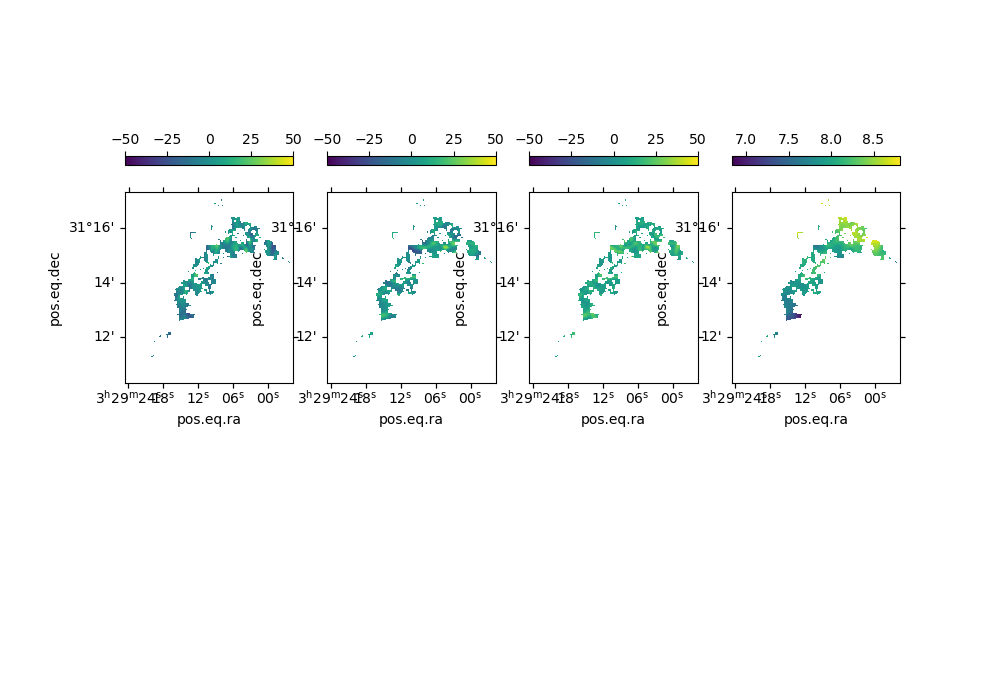

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharey=True, subplot_kw={'projection': wcssky}, figsize=(10,7))

im = ax[0].imshow(nablax_map, vmin=-50, vmax=50)
fig.colorbar(im, ax=ax[0], location='top')
im2 = ax[1].imshow(nablay_map, vmin=-50, vmax=50)
fig.colorbar(im2, ax=ax[1], location='top')
im3 = ax[2].imshow(absnabla_map, vmin=-50, vmax=50)
fig.colorbar(im3, ax=ax[2], location='top')
im4 = ax[3].imshow(vc_map)
fig.colorbar(im4, ax=ax[3], location='top')

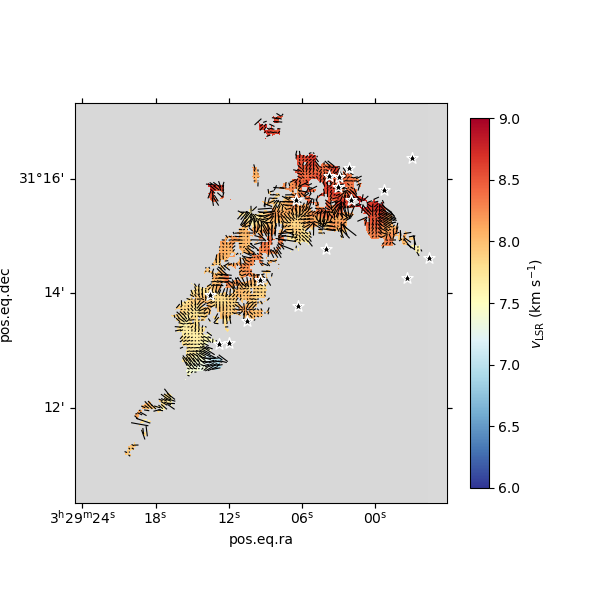

In [8]:
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')

xx = np.linspace(0, np.shape(absnabla_map)[1], np.shape(absnabla_map)[1])
yy = np.linspace(0, np.shape(absnabla_map)[0], np.shape(absnabla_map)[0])
# sample every n
ns = 4
xx2 = xx[2::ns].copy()
yy2 = yy[2::ns].copy()
vectorx2 = nablax_map[2::ns, 2::ns]
vectory2 = nablay_map[2::ns, 2::ns]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection=wcssky)
im = ax.imshow(velfield, origin='lower', cmap=cmap, vmin=6, vmax=9)
qui = ax.quiver(xx2, yy2, vectorx2, vectory2, scale=2, scale_units='y', pivot='mid', width=0.003, color='k', zorder=10, headwidth=0, headlength=0, headaxislength=0)

for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
fig.colorbar(im, ax=ax, pad=0.05, label=r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)', shrink=0.8)

ax.set_facecolor('0.85')
# fig.savefig((velgradbasefile.format('plot', molecule, clump))[:-5]+'.pdf')

The values look right, normally between -10 and 10 km/s/pc. 

## Divergence of velocity gradient (not used)

Now that we have the components of the velocity gradients, we can calculate the divergence.

Actually, there is a more straightforward way... the divergence of a gradient is called a Laplacian (of a scalar field). So, if we find an operator that calculates the sum of the second derivatives of our field directly, we do not need to calculate the divergence.

We test the Laplacian filter with numpy convolution. We would like to compare this to a brute force approach.

The brute force approach is to calculate the divergence of the gradient, by using the same function as what we used to calculate the gradients previously.

\begin{equation}
\nabla \cdot \vec{\nabla v} = \frac{\partial^2v}{\partial x^2} + \frac{\partial^2v}{\partial y^2}
\end{equation}

So, we take the maps $\vec{\nabla v}_x$ and $\vec{\nabla v}_y$, we do the gradients on those, and just take the map for the x direction for $\nabla(\vec{\nabla v}_x)$ and the y direction for $\nabla(\vec{\nabla v}_y)$ and add them up

In [9]:
divfile_brute = 'laplacian_velfield_diag_brute_pc_{0}_{1}.fits'.format(molecule, clump)
e_divfile_brute = 'laplacian_velfield_diag_brute_pc_unc_{0}_{1}.fits'.format(molecule, clump)
divfile_brute_magnitude = 'laplacian_velfield_diag_brute_pc_abs_{0}_{1}.fits'.format(molecule, clump)
overwrite = False

In [10]:
if not os.path.exists(divfile_brute) or overwrite:
    values_divx, errors_divx, jumped_divx = gradient(nablax_map, e_nablax_map, sampleradiuspix, minarea_calc, pixsize_pc, eps=1e-3)
    values_divy, errors_divy, jumped_divy = gradient(nablay_map, e_nablay_map, sampleradiuspix, minarea_calc, pixsize_pc, eps=1e-3)
    vxx = values_divx[0]
    vyy = values_divy[1]
    e_vxx = errors_divx[0]
    e_vyy = errors_divy[1]
    laplacian_map = vxx + vyy
    e_laplacian_map = e_vxx + e_vyy
    divheader = wcssky.to_header()
    divheader['BUNIT'] = 'km s-1 pc-2'
    fits.writeto(divfile_brute, laplacian_map, divheader, overwrite=True)
    fits.writeto(e_divfile_brute, e_laplacian_map, divheader, overwrite=True)
else:
    laplacian_map, divheader = fits.getdata(divfile_brute, header=True)
    e_laplacian_map = fits.getdata(e_divfile_brute)
if not os.path.exists(divfile_brute_magnitude) or overwrite:
    abs_laplacian_map = np.abs(laplacian_map)
    fits.writeto(divfile_brute_magnitude, abs_laplacian_map, divheader, overwrite=True)
else:
    abs_laplace_map = fits.getdata(divfile_brute_magnitude)

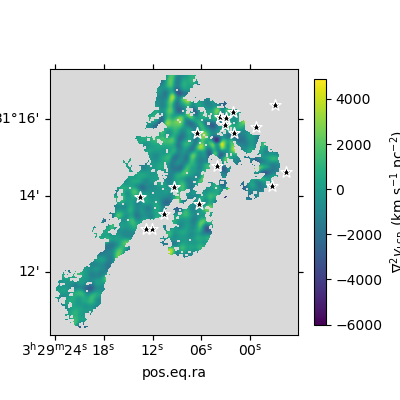

In [11]:
# we see more or less the values of the laplacian
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection=wcssky)
im = ax.imshow(laplacian_map, origin='lower')#, vmin=-1e4, vmax=1e4)
for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
    
ax.set_facecolor('0.85')
# ax.contour(fits.getdata('../data/NGC1333_HC3N_L24-merged_small_K_-3.0_18.0_mom0_filter.fits'), colors='k', levels=[0.3,0.5,1,2,3])
fig.colorbar(im, ax=ax, pad=0.05, label=r'$\nabla^2v_{\mathrm{LSR}}$ (km s$^{-1}$ pc$^{-2}$)', shrink=0.8)

fig.savefig(divfile_brute.format(molecule, clump)[:-5]+'.pdf')

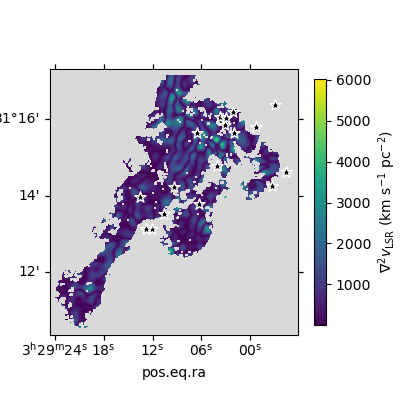

In [12]:
# we see more or less the values of the absolute of laplacian
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection=wcssky)
im = ax.imshow(np.abs(laplacian_map), origin='lower')#, vmin=-1e4, vmax=1e4)
for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70)
    
ax.set_facecolor('0.85')
# ax.contour(fits.getdata('../data/NGC1333_HC3N_L24-merged_small_K_-3.0_18.0_mom0_filter.fits'), colors='k', levels=[0.3,0.5,1,2,3])
fig.colorbar(im, ax=ax, pad=0.05, label=r'$\nabla^2v_{\mathrm{LSR}}$ (km s$^{-1}$ pc$^{-2}$)', shrink=0.8)

fig.savefig(divfile_brute.format(molecule, clump)[:-5]+'_abs.pdf')

## Defining fiber centers to compare the gradients quantitatively

## Comparison with polarization vectors
We load the polarization from BISTRO, which have a resolution of 14.1"

In [13]:
data_pol = ascii.read('../data/N1333_PA.csv')
ra_pol = np.rad2deg(data_pol['ra'])
dec_pol = np.rad2deg(data_pol['dec'])
dra_pol = np.sin(data_pol['PA'] + np.pi/2) * 2
ddec_pol = np.cos(data_pol['PA'] + np.pi/2) * 2



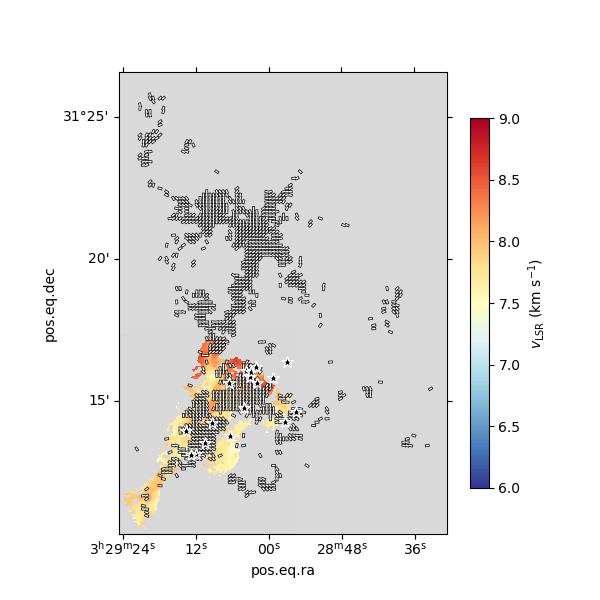

In [14]:
cmap = cm.get_cmap('RdYlBu_r').copy()
cmap.set_bad('0.85')

xx = np.linspace(0, np.shape(absnabla_map)[1], np.shape(absnabla_map)[1])
yy = np.linspace(0, np.shape(absnabla_map)[0], np.shape(absnabla_map)[0])
# sample every n
# ns = 5
# xx2 = xx[2::ns].copy()
# yy2 = yy[2::ns].copy()
# vectorx2 = nablax_map[2::ns, 2::ns]
# vectory2 = nablay_map[2::ns, 2::ns]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection=wcssky)
im = ax.imshow(velfield, origin='lower', cmap=cmap, vmin=6, vmax=9)
# qui = ax.quiver(xx2, yy2, vectorx2, vectory2, scale=2, scale_units='y', pivot='mid', width=0.003, color='k', zorder=10, headwidth=0, headlength=0, headaxislength=0)
# add polarisation vectors from BISTRO
for ra_i, dec_i, dra_i, ddec_i in zip(ra_pol, dec_pol, dra_pol, ddec_pol):
    position_i = SkyCoord(ra_i * u.deg, dec_i * u.deg, frame='fk5')
    # two pieces of coordinates
    position_vector_1 = position_i.spherical_offsets_by(dra_i * u.arcsec, ddec_i * u.arcsec)
    position_vector_2 = position_i.spherical_offsets_by(-dra_i * u.arcsec, -ddec_i * u.arcsec)
    ax.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
            [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=10, 
            color='black', transform=ax.get_transform('world'), lw=2)
    ax.plot([position_vector_1.ra.deg, position_vector_2.ra.deg], 
            [position_vector_1.dec.deg, position_vector_2.dec.deg], zorder=11,
            color='white', transform=ax.get_transform('world'), lw=1)


for i in catalog_protostars.index.values:
    ax.scatter(catalog_protostars.loc[i, 'RAJ2000'], catalog_protostars.loc[i, 'DEJ2000'], 
               transform=ax.get_transform('world'), marker='*', facecolor='k', edgecolor='w', s=70, zorder=100)
fig.colorbar(im, ax=ax, pad=0.05, label=r'$v_{\mathrm{LSR}}$ (km s$^{-1}$)', shrink=0.8)

ax.set_facecolor('0.85')
# fig.savefig((velgradbasefile.format('plot', molecule, clump))[:-5]+'.pdf')